# ⚛️ H₃⁺ Noisy VQE — UCC-S vs UCC-D vs UCCSD

This notebook benchmarks **noisy VQE** for the trihydrogen cation **H₃⁺** using three chemistry-inspired ansatzes via the package:

- **UCC-S** — singles only  
- **UCC-D** — doubles only  
- **UCCSD** — singles + doubles  

All of the following are handled entirely by the package:

- Molecular Hamiltonian construction  
- Ansatz construction (UCC-S / UCC-D / UCCSD)  
- Device selection (`default.mixed` for noisy runs)  
- Noise channels (depolarizing + amplitude damping)  
- Caching & reproducibility  

via the single high-level entrypoint:

```python
from vqe.core import run_vqe
```

This notebook is therefore a **pure client** of the VQE package — no manual QNodes, devices, or excitations are defined here.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from vqe_qpe_common.plotting import save_plot, build_filename
from vqe.core import run_vqe
from vqe_qpe_common.molecules import get_molecule_config
from vqe_qpe_common.molecule_viz import plot_molecule

seed = 0

# 🔧 Molecular System & Noise Model

We load the **H₃⁺** configuration from the shared molecule registry and then
fix a simple NISQ-style noise model:

- **Depolarizing noise:** 2% per qubit  
- **Amplitude damping:** 4% per qubit  

These values are intentionally a bit exaggerated so that the effect of noise
on different ansatzes is clearly visible.


In [ ]:
# Load H₃⁺ from the shared registry
mol = get_molecule_config("H3+")
print("Loaded H₃⁺ configuration:")
for k, v in mol.items():
    print(f"  {k}: {v}")

# Noise parameters (per qubit)
depolarizing_prob = 0.05
amplitude_damping_prob = 0.05

# Ansätze to compare
ansatzes = ["UCC-S", "UCC-D", "UCCSD"]
results = {}

# Fixed optimisation / run settings
optimizer_name = "Adam"
steps = 50
stepsize = 0.2


Loaded H₃⁺ configuration:
  symbols: ['H', 'H', 'H']
  coordinates: [[0.    0.    0.   ]
 [0.    0.    0.872]
 [0.755 0.    0.436]]
  charge: 1
  basis: STO-3G


<Axes: title={'center': 'H₃⁺ (equilateral triangular geometry)'}>

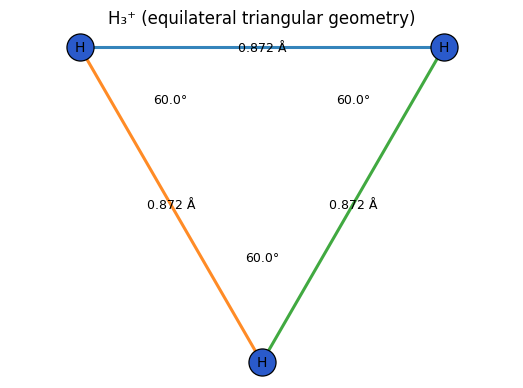

In [3]:
symbols = mol["symbols"]
coordinates = mol["coordinates"]

plot_molecule(
    symbols,
    coordinates,
    title="H₃⁺ (equilateral triangular geometry)",
    bonds=[(0, 1), (1, 2), (2, 0)],
    angles=[(0, 1, 2), (1, 2, 0), (2, 0, 1)],
    show_bond_lengths=True,
    show_atom_indices=False,
)


# 🚀 Run Noisy VQE for Each Ansatz

For each ansatz in:

- `"UCC-S"`, `"UCC-D"`, `"UCCSD"`

we call:

```python
run_vqe(
    molecule="H3+",
    ansatz_name=...,
    optimizer_name="Adam",
    steps=50,
    stepsize=0.2,
    noisy=True,
    depolarizing_prob=0.02,
    amplitude_damping_prob=0.04,
    seed=0,
)
```

`run_vqe`:

- builds the Hamiltonian and ansatz  
- creates a noisy `default.mixed` device  
- runs the optimisation loop  
- returns energies and the final (noisy) density matrix.


In [4]:
for ans in ansatzes:
    print(f"\n▶ Running NOISY VQE for H₃⁺ with ansatz: {ans}")
    res = run_vqe(
        molecule="H3+",
        ansatz_name=ans,
        optimizer_name=optimizer_name,
        steps=steps,
        stepsize=stepsize,
        noisy=True,
        depolarizing_prob=depolarizing_prob,
        amplitude_damping_prob=amplitude_damping_prob,
        seed=seed,
        plot=False,
        force=False,
    )
    results[ans] = res



▶ Running NOISY VQE for H₃⁺ with ansatz: UCC-S
Step 01/50: E = -1.091544 Ha
Step 02/50: E = -1.091223 Ha
Step 03/50: E = -1.091908 Ha
Step 04/50: E = -1.093171 Ha
Step 05/50: E = -1.091759 Ha
Step 06/50: E = -1.093395 Ha
Step 07/50: E = -1.096062 Ha
Step 08/50: E = -1.096209 Ha
Step 09/50: E = -1.094601 Ha
Step 10/50: E = -1.094235 Ha
Step 11/50: E = -1.095579 Ha
Step 12/50: E = -1.096777 Ha
Step 13/50: E = -1.096778 Ha
Step 14/50: E = -1.096268 Ha
Step 15/50: E = -1.096088 Ha
Step 16/50: E = -1.096331 Ha
Step 17/50: E = -1.096676 Ha
Step 18/50: E = -1.096942 Ha
Step 19/50: E = -1.097122 Ha
Step 20/50: E = -1.097127 Ha
Step 21/50: E = -1.096945 Ha
Step 22/50: E = -1.096834 Ha
Step 23/50: E = -1.097041 Ha
Step 24/50: E = -1.097398 Ha
Step 25/50: E = -1.097520 Ha
Step 26/50: E = -1.097329 Ha
Step 27/50: E = -1.097156 Ha
Step 28/50: E = -1.097258 Ha
Step 29/50: E = -1.097486 Ha
Step 30/50: E = -1.097571 Ha
Step 31/50: E = -1.097501 Ha
Step 32/50: E = -1.097447 Ha
Step 33/50: E = -1.09747

# 📉 Convergence Comparison

We now plot **energy vs iteration** for each ansatz under the same noisy
conditions. This highlights:

- how quickly each ansatz converges  
- whether they get trapped at different noisy optima  
- the relative robustness of UCC-S / UCC-D / UCCSD to this noise model


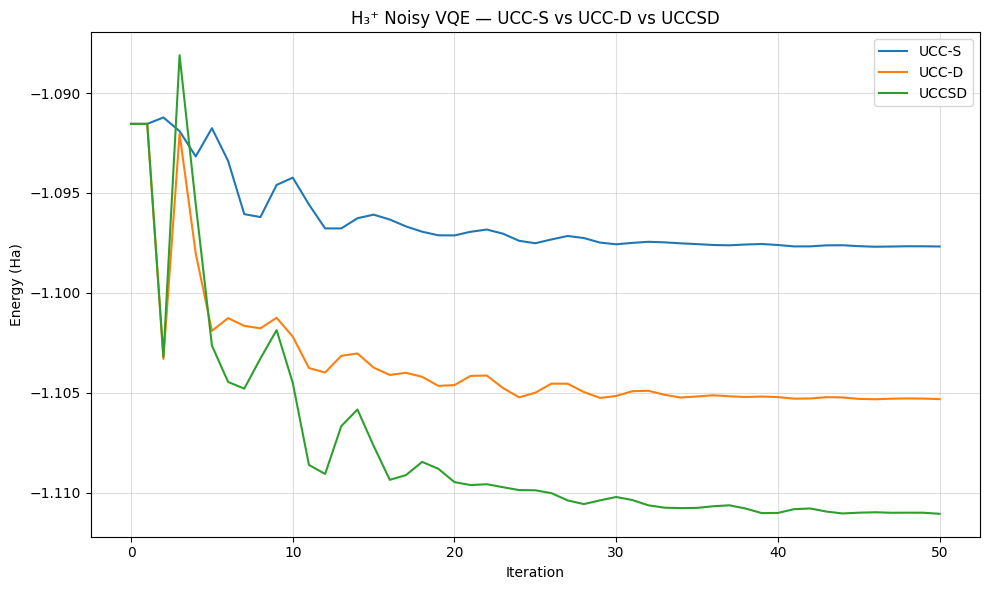

📁 Saved plot → /workspaces/Variational_Quantum_Eigensolver/images/vqe/H3plus/ansatz_conv_Adam_dep05_amp05_s0.png


'/workspaces/Variational_Quantum_Eigensolver/images/vqe/H3plus/ansatz_conv_Adam_dep05_amp05_s0.png'

In [ ]:
plt.figure(figsize=(10, 6))
for ans in ansatzes:
    plt.plot(results[ans]["energies"], label=ans)

plt.title("H₃⁺ Noisy VQE — UCC-S vs UCC-D vs UCCSD")
plt.xlabel("Iteration")
plt.ylabel("Energy (Ha)")
plt.legend()
plt.grid(True, alpha=0.4)
plt.tight_layout()

fname = build_filename(
    topic="ansatz_conv",
    optimizer=optimizer_name,
    dep=depolarizing_prob,
    amp=amplitude_damping_prob,
    seed=seed,
    multi_seed=False,
)
save_plot(fname, kind="vqe", molecule="H3+", show=True)


# 📊 Final Energies Summary

A quick table of the final energies for each ansatz:


In [6]:
print("\nFinal energies (noisy runs):")
for ans in ansatzes:
    print(f"  {ans:6s} → E = {results[ans]['energy']:.8f} Ha")



Final energies (noisy runs):
  UCC-S  → E = -1.09768234 Ha
  UCC-D  → E = -1.10532264 Ha
  UCCSD  → E = -1.11106566 Ha


# 🔬 Approximate Population Distributions

In the **noisy** setting (`default.mixed`), `run_vqe` stores the final
**density matrix** ρ via its real and imaginary components:

- `final_state_real`  
- `final_state_imag`

For intuition, we look at the **diagonal** of ρ:

$$
p_i = \rho_{ii}
$$

which gives the population of each computational basis state $|i⟩$.

We construct a compact, human-readable summary:

$$
\{p_i\}_i \quad \Rightarrow \quad \sum_i p_i |i⟩
$$

(This is **not** a true pure-state ket; it is just a convenient way
to report the diagonal populations.)


In [9]:
def approx_population(record, threshold: float = 1e-2) -> str:
    """
    Build a human-readable population summary from the stored state.

    Works for both:
      - pure states (statevector) → use |ψ_i|²
      - mixed states (density matrix) → use diag(ρ)
    """
    r = np.array(record["final_state_real"])
    i = np.array(record["final_state_imag"])
    state = r + 1j * i

    # Pure statevector case
    if state.ndim == 1:
        diag = np.abs(state) ** 2
    # Density matrix case
    elif state.ndim == 2:
        diag = np.real(np.diag(state))
    else:
        raise ValueError(f"Unexpected state shape: {state.shape}")

    n = int(np.log2(len(diag)))

    terms = [
        f"({p:.4f})|{idx:0{n}b}⟩"
        for idx, p in enumerate(diag)
        if p > threshold
    ]

    return " + ".join(terms) if terms else "(all populations below threshold)"

for ans in ansatzes:
    print("\n" + "-" * 70)
    print(f"Approximate population distribution for {ans}:")
    print(approx_population(results[ans], threshold=1e-2))



----------------------------------------------------------------------
Approximate population distribution for UCC-S:
(0.0620)|011000⟩ + (0.0625)|101000⟩ + (0.0620)|110000⟩ + (0.6969)|111000⟩ + (0.0230)|111001⟩ + (0.0228)|111010⟩ + (0.0228)|111100⟩

----------------------------------------------------------------------
Approximate population distribution for UCC-D:
(0.0615)|011000⟩ + (0.0615)|101000⟩ + (0.0615)|110000⟩ + (0.6919)|111000⟩ + (0.0226)|111001⟩ + (0.0226)|111010⟩ + (0.0226)|111100⟩

----------------------------------------------------------------------
Approximate population distribution for UCCSD:
(0.0588)|011000⟩ + (0.0593)|101000⟩ + (0.0612)|110000⟩ + (0.0285)|110010⟩ + (0.6613)|111000⟩ + (0.0218)|111001⟩ + (0.0225)|111010⟩ + (0.0216)|111100⟩
